In [286]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn.model_selection as skm
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay, classification_report, accuracy_score
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from ISLP import load_data, confusion_table
from ISLP.svm import plot as plot_svm

roc_curve = RocCurveDisplay.from_estimator

## Auto

In [287]:
Auto = load_data('Auto')
Auto.shape

(392, 8)

In [288]:
median_mpg = Auto['mpg'].median()
high_mpg = Auto['mpg'] > median_mpg
high_mpg.shape

(392,)

In [289]:
X = Auto.drop('mpg', axis='columns')
y = high_mpg
X.shape, y.shape

((392, 7), (392,))

### Linear SVM

In [295]:
def fit_svc_grid(svc_, param_grid, cv=5):
    grid = GridSearchCV(
        svc_, 
        param_grid, 
        refit=True, 
        cv=cv, 
        n_jobs=-1, 
        verbose=1,
    )
                
    return grid.fit(X, y)

def plot_svc_grid(svc_grid, Cs, title='SVC grid'):
    mean_scores = svc_grid.cv_results_['mean_test_score']

    _, ax = plt.subplots(figsize=(8,5))
    
    ax.plot(Cs, mean_scores)
    
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('C', fontsize=14)
    ax.set_ylabel('CV score', fontsize=14)
    ax.grid('on')

In [291]:
Cs = [.001, .01, .1, 1, 2, 5, 10]
degrees = [3, 4, 5]
params = dict(C=Cs)

svc_ = SVC(kernel='linear')
linear_svc_grid = fit_svc_grid(svc_, params, cv=2)

Fitting 2 folds for each of 7 candidates, totalling 14 fits


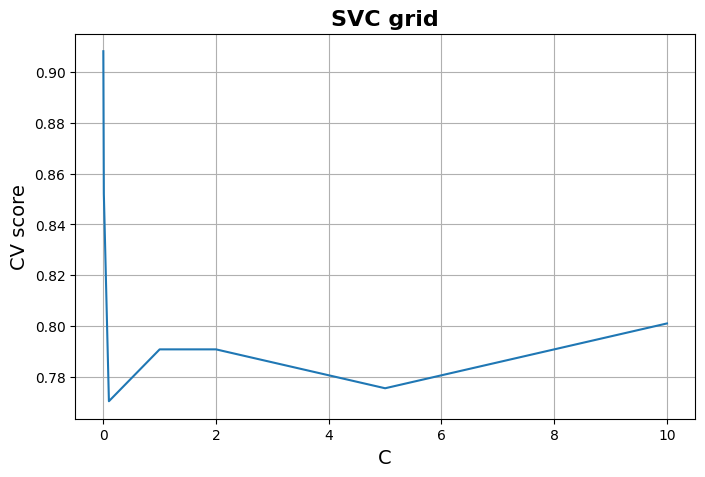

In [292]:
plot_svc_grid(linear_svc_grid, Cs)

### Polynomial SVM

In [293]:
params = dict(C=Cs, degree=degrees)
svc_ = SVC(kernel='poly')
poly_svc_grid = fit_svc(svc_, params)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


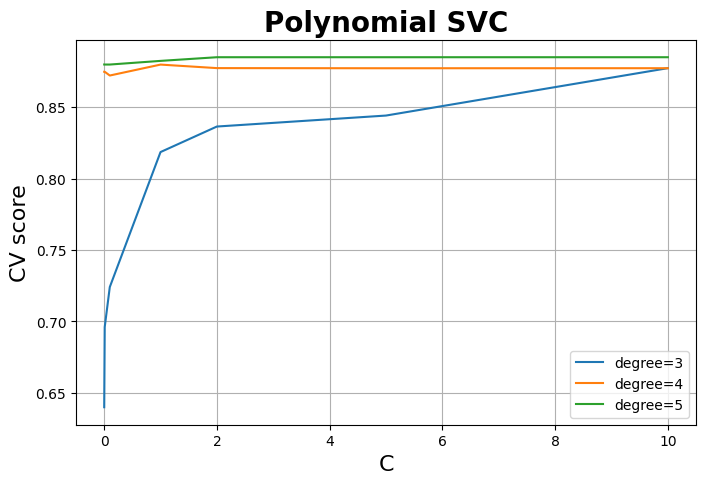

In [294]:
mean_scores = poly_svc_grid.cv_results_['mean_test_score']

mean_scores = np.array(mean_scores).reshape(len(degrees), len(Cs))

_, ax = plt.subplots(figsize=(8, 5))

for i, degree in enumerate(degrees):
    ax.plot(Cs, mean_scores[i, :], label=f'degree={degree}')

ax.set_title("Polynomial SVC", fontsize=20, fontweight='bold')
ax.set_xlabel('C', fontsize=16)
ax.set_ylabel('CV score', fontsize=16)
ax.legend(loc="best")
ax.grid('on')

### Radial SVC

In [296]:
params = dict(C=Cs, degree=degrees)
svc_ = SVC(kernel='rbf')
radial_svc_grid = fit_svc_grid(svc_, params)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


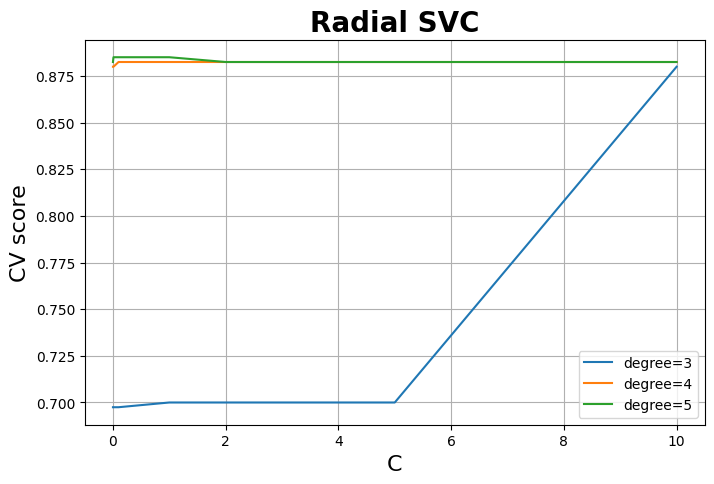

In [297]:
mean_scores = radial_svc_grid.cv_results_['mean_test_score']

mean_scores = np.array(mean_scores).reshape(len(degrees), len(Cs))

_, ax = plt.subplots(figsize=(8,5))

for i, degree in enumerate(degrees):
    ax.plot(Cs, mean_scores[i, :], label=f'degree={degree}')

ax.set_title("Radial SVC", fontsize=20, fontweight='bold')
ax.set_xlabel('C', fontsize=16)
ax.set_ylabel('CV score', fontsize=16)
ax.legend(loc="best")
ax.grid('on')

## OJ

In [298]:
OJ = load_data('OJ')
OJ.shape

(1070, 18)

### Train/test split

In [299]:
X = OJ.drop('Purchase', axis='columns')
y = OJ['Purchase']
X.shape, y.shape

((1070, 17), (1070,))

In [300]:
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, train_size=800, random_state=42, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 17), (270, 17), (800,), (270,))

In [301]:
cat_features = [x for x in X.columns if X[x].dtype == 'category']
num_features = [x for x in X.columns if x not in cat_features]
cat_features, num_features

(['Store7'],
 ['WeekofPurchase',
  'StoreID',
  'PriceCH',
  'PriceMM',
  'DiscCH',
  'DiscMM',
  'SpecialCH',
  'SpecialMM',
  'LoyalCH',
  'SalePriceMM',
  'SalePriceCH',
  'PriceDiff',
  'PctDiscMM',
  'PctDiscCH',
  'ListPriceDiff',
  'STORE'])

### Column transformer

In [302]:
ct = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', 'passthrough', num_features)
])
ct

ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Store7']),
                                ('num', 'passthrough',
                                 ['WeekofPurchase', 'StoreID', 'PriceCH',
                                  'PriceMM', 'DiscCH', 'DiscMM', 'SpecialCH',
                                  'SpecialMM', 'LoyalCH', 'SalePriceMM',
                                  'SalePriceCH', 'PriceDiff', 'PctDiscMM',
                                  'PctDiscCH', 'ListPriceDiff', 'STORE'])])

### Linear SVC

In [303]:
oj_linear_svc = Pipeline([
    ('ct', ct),
    ('clf', SVC(C=.01)),
])

oj_linear_svc.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Store7']),
                                                 ('num', 'passthrough',
                                                  ['WeekofPurchase', 'StoreID',
                                                   'PriceCH', 'PriceMM',
                                                   'DiscCH', 'DiscMM',
                                                   'SpecialCH', 'SpecialMM',
                                                   'LoyalCH', 'SalePriceMM',
                                                   'SalePriceCH', 'PriceDiff',
                                                   'PctDiscMM', 'PctDiscCH',
                                                   'ListPriceDiff',
                                                   'STORE'])])),
                ('clf', SVC(C=0.01))])

We see that there are 300 support vectors for each class.

In [304]:
clf_ = oj_linear_svc.named_steps['clf']
clf_.n_support_

array([306, 306], dtype=int32)

#### Base train/test accuracy

In [305]:
y_train_hat = oj_linear_svc.predict(X_train)
y_test_hat = oj_linear_svc.predict(X_test)

accuracy_score(y_train, y_train_hat), accuracy_score(y_test, y_test_hat)

(0.6175, 0.5888888888888889)

#### Tuning on C

In [317]:
oj_linear_svc_ = Pipeline([
    ('ct', ct),
    ('clf', SVC(kernel='linear')),
])

Cs = np.array([.01, .1, 1, 2, 5, 10])
params = {'clf__C': Cs}
oj_linear_grid = fit_svc_grid(oj_linear_svc_, params, cv=2)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


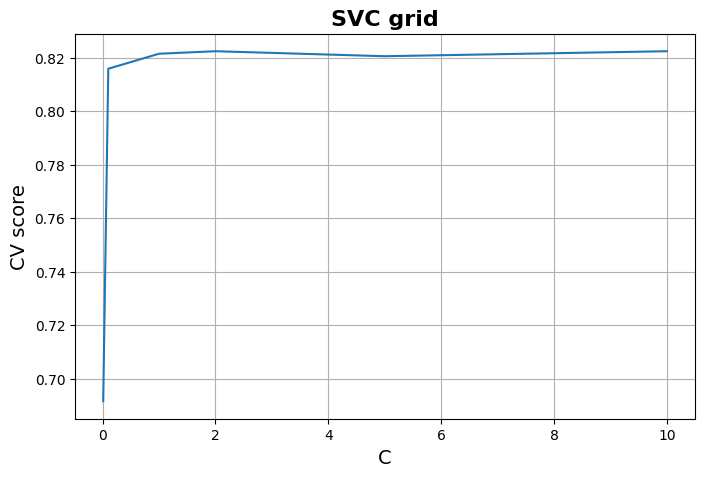

In [318]:
plot_svc_grid(oj_linear_grid, Cs)

#### Tuned train/test accuracy

In [319]:
best_ = oj_linear_grid.best_estimator_
y_train_hat = best_.predict(X_train)
y_test_hat = best_.predict(X_test)

accuracy_score(y_train, y_train_hat), accuracy_score(y_test, y_test_hat)

(0.84875, 0.8148148148148148)

### Radial SVC

In [320]:
oj_radial_svc = Pipeline([
    ('ct', ct),
    ('clf', SVC(C=.01, kernel='rbf')),
])

oj_radial_svc.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Store7']),
                                                 ('num', 'passthrough',
                                                  ['WeekofPurchase', 'StoreID',
                                                   'PriceCH', 'PriceMM',
                                                   'DiscCH', 'DiscMM',
                                                   'SpecialCH', 'SpecialMM',
                                                   'LoyalCH', 'SalePriceMM',
                                                   'SalePriceCH', 'PriceDiff',
                                                   'PctDiscMM', 'PctDiscCH',
                                                   'ListPriceDiff',
                                                   'STORE'])])),
                ('clf', SVC(C=0.01))])

#### Base train/test accuracy

In [275]:
y_train_hat = oj_radial_svc.predict(X_train)
y_test_hat = oj_radial_svc.predict(X_test)

accuracy_score(y_train, y_train_hat), accuracy_score(y_test, y_test_hat)

(0.6175, 0.5888888888888889)

#### Tuning on C

In [276]:
oj_radial_svc_ = Pipeline([
    ('ct', ct),
    ('clf', SVC(kernel='rbf')),
])

params = {'clf__C': Cs}
oj_radial_grid = fit_svc_grid(oj_radial_svc_, params)
oj_radial_grid

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Store7']),
                                                                        ('num',
                                                                         'passthrough',
                                                                         ['WeekofPurchase',
                                                                          'StoreID',
                                                                          'PriceCH',
                                                                          'PriceMM',
                                                                          'DiscCH',
                                                                          'DiscMM',
                                                                          'SpecialCH',
                                                                          'SpecialMM',
                                                                          'LoyalCH',
                                                                          'SalePriceMM',
                                                                          'SalePriceCH',
                                                                          'PriceDiff',
                                                                          'PctDiscMM',
                                                                          'PctDiscCH',
                                                                          'ListPriceDiff',
                                                                          'STORE'])])),
                                       ('clf', SVC())]),
             n_jobs=-1, param_grid={'clf__C': [0.01, 0.1, 1, 2, 5, 10]},
             verbose=1)

Best params and score.

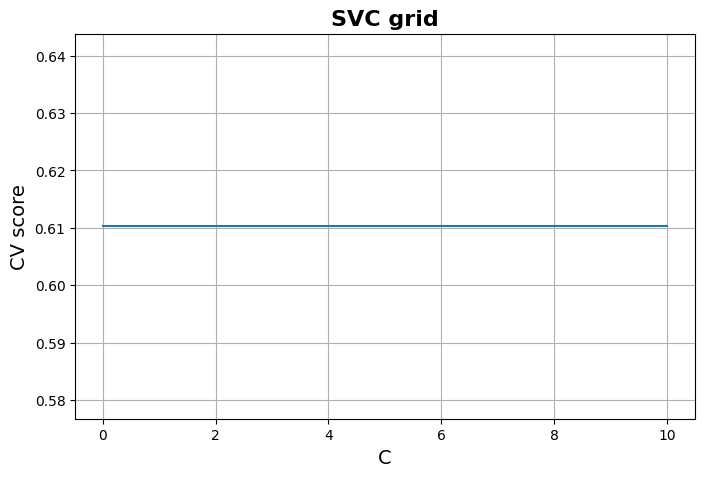

In [321]:
plot_svc_grid(oj_radial_grid, Cs)

#### Tuned train/test accuracy

In [322]:
best_ = oj_radial_grid.best_estimator_
y_train_hat = best_.predict(X_train)
y_test_hat = best_.predict(X_test)

accuracy_score(y_train, y_train_hat), accuracy_score(y_test, y_test_hat)

(0.6175, 0.5888888888888889)

### Polynomial SVC

In [323]:
oj_poly_svc = Pipeline([
    ('ct', ct),
    ('clf', SVC(C=.01, kernel='poly', degree=2)),
])

oj_poly_svc.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Store7']),
                                                 ('num', 'passthrough',
                                                  ['WeekofPurchase', 'StoreID',
                                                   'PriceCH', 'PriceMM',
                                                   'DiscCH', 'DiscMM',
                                                   'SpecialCH', 'SpecialMM',
                                                   'LoyalCH', 'SalePriceMM',
                                                   'SalePriceCH', 'PriceDiff',
                                                   'PctDiscMM', 'PctDiscCH',
                                                   'ListPriceDiff',
                                                   'STORE'])])),
                ('clf', SVC(C=0.01, degree=2, kernel='poly'))])

#### Base train/test accuracy

In [324]:
y_train_hat = oj_poly_svc.predict(X_train)
y_test_hat = oj_poly_svc.predict(X_test)

accuracy_score(y_train, y_train_hat), accuracy_score(y_test, y_test_hat)

(0.6175, 0.5888888888888889)

#### Tuning on C

In [281]:
oj_poly_svc_ = Pipeline([
    ('ct', ct),
    ('clf', SVC(kernel='poly')),
])

params = {'clf__C': Cs}
oj_poly_grid = fit_svc_grid(oj_poly_svc_, params)
oj_poly_grid

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Store7']),
                                                                        ('num',
                                                                         'passthrough',
                                                                         ['WeekofPurchase',
                                                                          'StoreID',
                                                                          'PriceCH',
                                                                          'PriceMM',
                                                                          'DiscCH',
                                                                          'DiscMM',
                                                                          'SpecialCH',
                                                                          'SpecialMM',
                                                                          'LoyalCH',
                                                                          'SalePriceMM',
                                                                          'SalePriceCH',
                                                                          'PriceDiff',
                                                                          'PctDiscMM',
                                                                          'PctDiscCH',
                                                                          'ListPriceDiff',
                                                                          'STORE'])])),
                                       ('clf', SVC(kernel='poly'))]),
             n_jobs=-1, param_grid={'clf__C': [0.01, 0.1, 1, 2, 5, 10]},
             verbose=1)

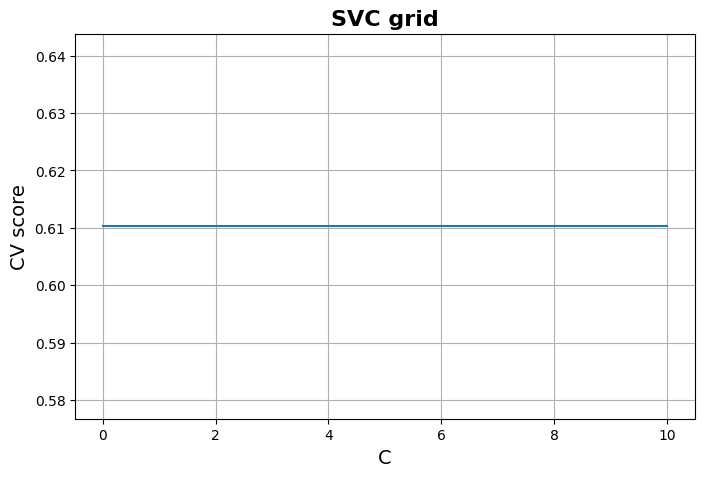

In [325]:
plot_svc_grid(oj_poly_grid, Cs)

#### Tuned train/test accuracy

In [326]:
best_ = oj_poly_grid.best_estimator_
y_train_hat = best_.predict(X_train)
y_test_hat = best_.predict(X_test)

accuracy_score(y_train, y_train_hat), accuracy_score(y_test, y_test_hat)

(0.6175, 0.5888888888888889)

### Conclusion

Based on the results, the linear kernel has the best performance, while radial and polynomial kernels look exactly the same.